# Introduction to FEM Analysis with Python

In this tutorial, we will use Python to pre-processing, solve, and post-processing of Finite Element Method analysis. It uses a finite element method library with a Python interface called [GetFEM](http://getfem.org/) for preprocessing and solving. This tutorial was used in the [PyConJP 2019 talk](https://pycon.jp/2019/schedule/?sessionId=120). You can watch the talk on YouTube below. We will load vtk file by using [meshio](https://github.com/nschloe/meshio) and visualize by [matplotlib](https://github.com/matplotlib/matplotlib) in pre-processing and post-processing.

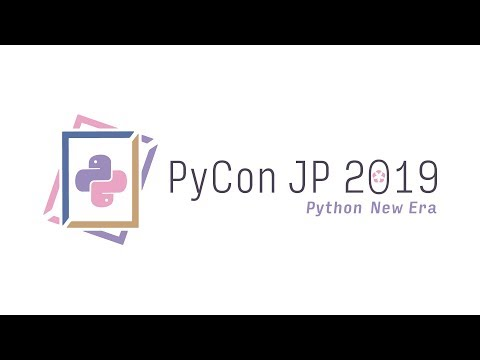

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("6JuB1GiDLQQ", start=512)

## What is PDE and FEM?

PDE is a equation using in science and engineering. For example, the following expression is a PDE:

$$−\Delta u=1$$

[FEM](https://en.wikipedia.org/wiki/Finite_element_method) is a method of solving PDE.

$$[K] \left\{ u \right\} = \left\{ F \right\}$$

## What is GetFEM?
This library provides a framework for solving PDE by FEM.

![shape3](http://getfem.org/_images/shape3.png)
![shape4](http://getfem.org/_images/shape4.png)

## Release Notes
[Release Notes Version 5.4](http://getfem.org/whatsnew/5.4.html) @2020/04/22

[Release Notes Version 5.3](http://getfem.org/whatsnew/5.3.html) @2018/06/22

[Release Notes Version 5.2](http://getfem.org/whatsnew/5.2.html) @2017/06/30

[Release Notes Version 5.1](http://getfem.org/whatsnew/5.1.html) @2016/08/18

[Release Notes Version 5.0](http://getfem.org/whatsnew/5.0.html) @2015/07/29

😯 Development has continued since the 1990s!

# Installation

It is easy to install by apt.

Let's install from source code to study

Run ***./configure***
- --with-pic 💡 options for 64 bit compilation
- --enable-python3=yes 💡 option to use python3

## Using Library

- 🔖 Qhull 💡 mesh generation.
- 🔖 MUMPS 💡 parallel calculation.
- 🔖 LAPACK/BLAS 💡 Linear Algebra
- 🔖 Numpy/Scipy 💡 Numerical computation

![mesh1](https://raw.githubusercontent.com/tkoyama010/OpenCAE-tkoyama010/PyConJP2019/mesh1.png)

💁 Compile Test Install

## 🏃 Tutorial

![pdedemo1_01](https://jp.mathworks.com/help/examples/pde/win64/pdedemo1_01.png)

$$−\Delta u=1 \ {\rm on}\  \Omega, u=0 \ {\rm on}\  \delta \Omega $$

In [2]:
%matplotlib inline
import getfem as gf
import numpy as np
import matplotlib.pyplot as plt
import meshio

In [3]:
# Approximate mesh length
h = 0.1
elements_degree = 2
F = 1.0

## 🏃 Mesher Object

![pdedemo1_01](https://jp.mathworks.com/help/examples/pde/win64/pdedemo1_01.png)

We use GetFEM's [MesherObject](http://getfem.org/python/cmdref_MesherObject.html#) to create a mesh from the geometric information to be analyzed.
This object represents a geometric object to be meshed by the experimental meshing procedure of GetFEM. We can represents a ball of corresponding center and radius by using "ball".

In [4]:
center = [1.0, 1.0]
radius = 1.0

mo = gf.MesherObject("ball", center, radius)

We can make mesh object `mesh` by calling the experimental mesher of GetFEM on the geometry represented by `mo`.

In [5]:
mesh = gf.Mesh("generate", mo, h, 2)

We visualize the created mesh to check its quality.

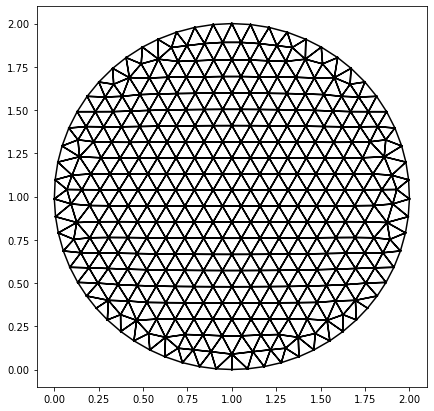

In [6]:
sl = gf.Slice(("none",), mesh, 1)
sl.export_to_vtk("sl.vtk", "ascii")

reader = meshio.read("sl.vtk")
x = reader.points
triangles = reader.cells[0][1]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(7, 7))
plt.triplot(x[:, 0], x[:, 1], triangles, color="black")

## 🏃 Move Mesh and Set Region

In [7]:
mesh.translate([-1.0, -1.0])
fb = mesh.outer_faces()
OUTER_BOUND = 1
mesh.set_region(OUTER_BOUND, fb)

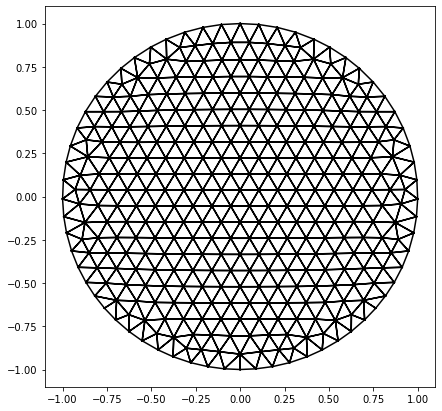

In [8]:

sl = gf.Slice(("none",), mesh, 1)
sl.export_to_vtk("sl.vtk", "ascii")

reader = meshio.read("sl.vtk")
x = reader.points
triangles = reader.cells[0][1]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(7, 7))
plt.triplot(x[:, 0], x[:, 1], triangles, color="black")

## 🏃 [MeshFem](http://getfem.org/python/cmdref_MeshFem.html?highlight=meshfem%20object) Object

![Lagrange Element](https://raw.githubusercontent.com/tkoyama010/OpenCAE-tkoyama010/PyConJP2019/getfemlisttriangleP2.png)

In [9]:
# The node has 1 degree of freedom
mfu = gf.MeshFem(mesh, 1)

# classical lagrange elements
mfu.set_classical_fem(elements_degree)

In [10]:
mim = gf.MeshIm(mesh, pow(elements_degree, 2))

## 🏃 [Model Object](http://getfem.org/userdoc/model_object.html)

$$ [K] \left\{ u \right\} = \left\{ F \right\} $$

In [11]:
md = gf.Model("real")
md.add_fem_variable("u", mfu)

## 🏃 Laplacian Brick, RHS and condition 

$$−\Delta u=1 \ {\rm on}\  \Omega, u=0 \ {\rm on}\  \delta \Omega $$
to
$$[K] \left\{ u \right\} = \left\{ F \right\}$$

In [12]:
md.add_Laplacian_brick(mim, "u")

0

In [13]:
md.add_fem_data("F", mfu)
md.add_source_term_brick(mim, "u", "F")
md.set_variable("F", np.repeat(F, mfu.nbdof()))

In [14]:
md.add_Dirichlet_condition_with_multipliers(mim, "u", elements_degree - 1, OUTER_BOUND)

2

## 🏃 Solve $u$

$$[K] \left\{ u \right\} = \left\{ F \right\}$$

In [15]:
md.solve()
U = md.variable("u")

## 🎉 variable ***u***

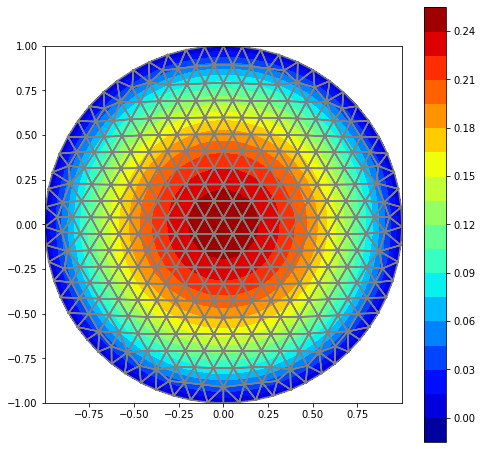

In [19]:
sl.export_to_vtk("u.vtk", "ascii", mfu, U, "U")
reader = meshio.read("u.vtk")
x = reader.points
triangles = reader.cells[0][1]
point_data = reader.point_data["U"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")
contour = plt.tricontourf(x[:, 0], x[:, 1], triangles, point_data, 16, cmap="jet")
plt.colorbar(contour)
plt.gca().set_aspect("equal")

## theoretical solution
$$u(x, y) = \dfrac{1-x^2-y^2}{4}$$

In [17]:
xy = mfu.basic_dof_nodes()
x = xy[0, :]
y = xy[1, :]
sol = (1 - x * x - y * y) / 4.0

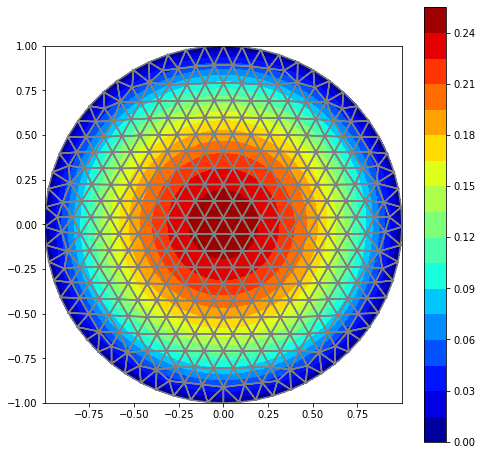

In [20]:
sl.export_to_vtk("sol.vtk", "ascii", mfu, sol, "solution")

reader = meshio.read("sol.vtk")
x = reader.points
triangles = reader.cells[0][1]
point_data = reader.point_data["solution"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")
contour = plt.tricontourf(x[:, 0], x[:, 1], triangles, point_data, 16, cmap="jet")
plt.colorbar(contour)
plt.gca().set_aspect("equal")